In [1]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime

In [2]:
#connection = cx_Oracle.connect('HCIN_GUPTAN1[AP_UWI]/aGqQ4jnX92NG@INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
#cursor = connection.cursor()
#os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")
# qu1= """
# select * from TMP_BD_GRID_DISTANCE_ID
# where risk_agrf120 =1 
# """
#df = pd.read_sql(qu1,connection)
#df.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.pkl")
#df.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.csv")

In [103]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.pkl")

In [104]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FSTQPD30,RISK_AGRF120,PRODUCT_GROUP,CLIENT_EXI_3M,RISK_SCORE,RNK
0,154206937,2018-01-02,12.913236,77.699678,0,1,CD,N,0.021106,1
1,154432501,2018-01-02,28.725803,77.175379,0,1,CD,N,0.027432,1
2,154536129,2018-01-01,25.313181,82.953024,1,1,CD,N,0.034592,1
3,154536988,2018-01-01,21.320343,72.868642,0,1,CD,N,0.042080,1
4,154545377,2018-01-01,22.690763,75.828938,0,1,CD,N,0.008329,1


In [105]:
df.dropna(subset = ["RISK_SCORE"], inplace = True)

In [106]:
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%Y-%m")
df_summ = df.groupby("MONTH_STR").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

KeyboardInterrupt: 

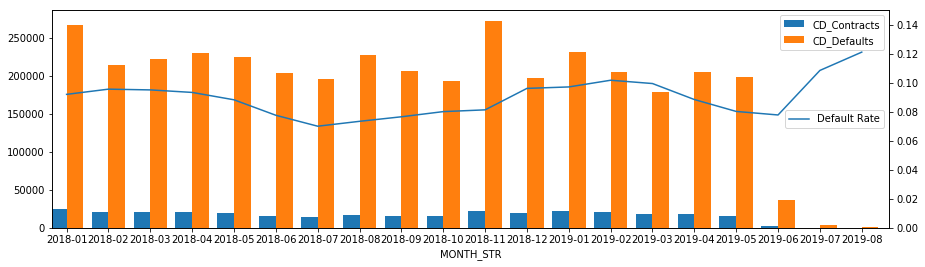

In [7]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [9]:
df_test_final = df_test.head()

In [10]:
df_test_final

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FSTQPD30,RISK_AGRF120,PRODUCT_GROUP,RISK_SCORE,RNK,MONTH_STR
2868826,223563879,2019-02-01,22.271400,70.779590,1,1,CD,0.015552,1,2019-02
2874185,223672260,2019-02-03,22.758185,86.212367,0,1,CD,0.015991,1,2019-02
2874436,223673200,2019-02-03,30.848835,75.888499,0,1,CD,0.024406,1,2019-02
2875137,223676221,2019-02-04,9.998186,76.397605,1,1,CD,0.011368,1,2019-02
2875564,223678061,2019-02-02,22.296405,70.794156,0,1,CD,0.004911,1,2019-02


In [87]:
df_final_test = pd.DataFrame()

import datetime
from sklearn.neighbors import KNeighborsClassifier

for x in np.arange(1,6,1):
    
    date_train_start = datetime.datetime(2018, x, 1)
    date_train_end = (date_train_start.replace(day=1)).replace(year=2019)
    date_test_end = (date_train_end.replace(day=1) + datetime.timedelta(days=31)).replace(day=1)

    start_time = datetime.datetime.now()
    df_train = df[(df["TIME_DECISION_DATE"]>=date_train_start) & 
              (df["TIME_DECISION_DATE"]<date_train_end)]
    df_test = df[(df["TIME_DECISION_DATE"]>=date_train_end) & 
                  (df["TIME_DECISION_DATE"]<date_test_end)]


    count_class_0, count_class_1 = df_train.RISK_FSTQPD30.value_counts()
    df_class_0 = df_train[df_train['RISK_FSTQPD30'] == 0]
    df_class_1 = df_train[df_train['RISK_FSTQPD30'] == 1]
    df_class_0_under = df_class_0.sample(200000)
    df_class_1_under = df_class_1.sample(200000)
    df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

    X_train = df_train_under[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]
    X_test = df_test[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]

    y_train = df_train_under["RISK_FSTQPD30"]
    y_test =  df_test["RISK_FSTQPD30"]



    knn = KNeighborsClassifier(n_neighbors = 400)
    bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

    ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
    ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

    metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1

    
    df_test['PRED_SCORE'] = ypred_test
    
    if df_final_test.shape == (0,0):
        df_final_test = df_test
    else:
        df_final_test = pd.concat([df_final_test,df_test],ignore_index=True)

    print("Training for predicting (month):",date_train_start.month, "    GINI TRAIN:",'{:,.2%}'.format(gini_train), "    GINI TEST:",'{:,.2%}'.format(gini_test),
         "    time taken: ",'{:,.2}'.format((datetime.datetime.now()-start_time).seconds/60))




C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1     GINI TRAIN: 15.63%     GINI TEST: 12.13%     time taken:  1.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2     GINI TRAIN: 15.63%     GINI TEST: 12.06%     time taken:  1.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3     GINI TRAIN: 15.88%     GINI TEST: 11.24%     time taken:  1.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 4     GINI TRAIN: 15.57%     GINI TEST: 10.88%     time taken:  1.1


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 5     GINI TRAIN: 15.33%     GINI TEST: 11.03%     time taken:  1.1


In [93]:
df_final_test.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FSTQPD30,RISK_AGRF120,PRODUCT_GROUP,RISK_SCORE,RNK,MONTH_STR,PRED_SCORE,LOGIT_RISK_SCORE,LOGIT_PRED_SCORE,COMBINED_SCORE
0,219906800,2019-01-01,18.637497,73.836025,0,1,CD,0.020050,1,2019-01,0.4550,-3.889290,-0.180488,0.139250
1,219993472,2019-01-01,23.194511,77.462190,0,1,CD,0.021875,1,2019-01,0.4600,-3.800296,-0.160343,0.149164
2,220099958,2019-01-01,28.504690,77.231656,1,1,CD,0.020797,1,2019-01,0.4850,-3.851954,-0.060018,0.152911
3,220101732,2019-01-02,18.635453,73.792278,0,1,CD,0.008695,1,2019-01,0.4950,-4.736259,-0.020001,0.087244
4,220365451,2019-01-01,26.245851,78.180434,0,1,CD,0.009002,1,2019-01,0.4725,-4.701276,-0.110111,0.084512


In [91]:
df_final_test["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df_final_test["RISK_SCORE"]]
df_final_test["LOGIT_PRED_SCORE"] = [np.log(x/(1-x)) for x in df_final_test["PRED_SCORE"]]

In [92]:
df_final_test["COMBINED_SCORE"]= 1/(1+np.exp(-(df_final_test["LOGIT_RISK_SCORE"]*0.74964582+ 
              df_final_test["LOGIT_PRED_SCORE"]*0.67726671 + 1.21629788)))

In [97]:

print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"], df_final_test["COMBINED_SCORE"]) - 1))
print("GINI HC: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"], df_final_test["RISK_SCORE"]) - 1))
print("GINI KNN: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"], df_final_test["PRED_SCORE"]) - 1))


GINI COMBINED:  27.09%
GINI HC:  24.99%
GINI KNN:  11.64%


In [90]:
df_combined_score=df_final_test[['RISK_SCORE','PRED_SCORE','RISK_FSTQPD30','SKP_CREDIT_CASE', 'TIME_DECISION_DATE']]

In [101]:
#Calculate Gini Lift Logistic Regression
from sklearn.linear_model import LogisticRegression
comb=LogisticRegression()
comb.fit(df_combined_score[['RISK_SCORE','PRED_SCORE']],df_combined_score["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [102]:
y_pred_comb=comb.predict_proba(df_combined_score[['RISK_SCORE','PRED_SCORE']])[:,1]

In [103]:
metric_auc_combined = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], y_pred_comb)
metric_auc_knn = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["PRED_SCORE"])
metric_auc_hc = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["RISK_SCORE"])


gini_combined = 2 * metric_auc_combined - 1
gini_knn = 2 * metric_auc_knn - 1
gini_hc = 2 * metric_auc_hc - 1

In [104]:
print("gini_combined:",'{:,.2%}'.format(gini_combined))
print("\ngini_knn:",'{:,.2%}'.format(gini_knn))
print("\ngini_hc:",'{:,.2%}'.format(gini_hc))

gini_combined: 24.86%

gini_knn: 11.76%

gini_hc: 25.02%


In [105]:
#Calculate Gini Lift Linear Regression
from sklearn.linear_model import LinearRegression
comb=LinearRegression()
comb.fit(df_combined_score[['RISK_SCORE','PRED_SCORE']],df_combined_score["RISK_FSTQPD30"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [106]:
y_pred_comb=comb.predict(df_combined_score[['RISK_SCORE','PRED_SCORE']])

In [107]:
metric_auc_combined = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], y_pred_comb)
metric_auc_knn = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["PRED_SCORE"])
metric_auc_hc = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["RISK_SCORE"])


gini_combined = 2 * metric_auc_combined - 1
gini_knn = 2 * metric_auc_knn - 1
gini_hc = 2 * metric_auc_hc - 1

In [108]:
print("gini_combined:",'{:,.2%}'.format(gini_combined))
print("\ngini_knn:",'{:,.2%}'.format(gini_knn))
print("\ngini_hc:",'{:,.2%}'.format(gini_hc))

gini_combined: 26.57%

gini_knn: 11.76%

gini_hc: 25.02%


In [109]:
df_combined_score["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df_combined_score["RISK_SCORE"]]
df_combined_score["LOGIT_PRED_SCORE"] = [np.log(x/(1-x)) for x in df_combined_score["PRED_SCORE"]]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [110]:
#Calculate Gini Lift Logistic Regression (p/1-p) transformation
from sklearn.linear_model import LogisticRegression
comb=LogisticRegression()
comb.fit(df_combined_score[['LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']],df_combined_score["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [111]:
y_pred_comb=comb.predict_proba(df_combined_score[['LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']])[:,1]

In [112]:
metric_auc_combined = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], y_pred_comb)
metric_auc_knn = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["PRED_SCORE"])
metric_auc_hc = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["RISK_SCORE"])


gini_combined = 2 * metric_auc_combined - 1
gini_knn = 2 * metric_auc_knn - 1
gini_hc = 2 * metric_auc_hc - 1

In [113]:
print("gini_combined:",'{:,.2%}'.format(gini_combined))
print("\ngini_knn:",'{:,.2%}'.format(gini_knn))
print("\ngini_hc:",'{:,.2%}'.format(gini_hc))

gini_combined: 27.18%

gini_knn: 11.76%

gini_hc: 25.02%


In [118]:
df_combined_score["COMB_SCORE"] = y_pred_comb
df_combined_score.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Combined_Scores.pkl")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [85]:
#Check Stability of Combined Model
seed = 25522
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(df_combined_score[["PRED_SCORE","RISK_SCORE",'LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']],df_combined_score["RISK_FSTQPD30"], test_size=test_size, random_state=seed)


In [96]:
from sklearn.linear_model import LogisticRegression
comb=LogisticRegression()
comb.fit(X_train[['LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']],y_train)
y_pred_comb_train=comb.predict_proba(X_train[['LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']])[:,1]
y_pred_comb_test=comb.predict_proba(X_test[['LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']])[:,1]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [97]:
metric_auc_combined_train = metrics.roc_auc_score(y_train, y_pred_comb_train)
metric_auc_knn_train = metrics.roc_auc_score(y_train, X_train["PRED_SCORE"])
metric_auc_hc_train = metrics.roc_auc_score(y_train, X_train["RISK_SCORE"])

metric_auc_combined_test = metrics.roc_auc_score(y_test, y_pred_comb_test)
metric_auc_knn_test = metrics.roc_auc_score(y_test, X_test["PRED_SCORE"])
metric_auc_hc_test = metrics.roc_auc_score(y_test, X_test["RISK_SCORE"])



gini_combined_train = 2 * metric_auc_combined_train - 1
gini_knn_train = 2 * metric_auc_knn_train - 1
gini_hc_train = 2 * metric_auc_hc_train- 1

gini_combined_test = 2 * metric_auc_combined_test - 1
gini_knn_test = 2 * metric_auc_knn_test - 1
gini_hc_test = 2 * metric_auc_hc_test- 1

print("gini_combined_train:",'{:,.2%}'.format(gini_combined_train))
print("\ngini_knn_train:",'{:,.2%}'.format(gini_knn_train))
print("\ngini_hc_train:",'{:,.2%}'.format(gini_hc_train))

print("\ngini_combined_test:",'{:,.2%}'.format(gini_combined_test))
print("\ngini_knn_test:",'{:,.2%}'.format(gini_knn_test))
print("\ngini_hc_test:",'{:,.2%}'.format(gini_hc_test))


gini_combined_train: 27.34%

gini_knn_train: 11.90%

gini_hc_train: 25.15%

gini_combined_test: 26.82%

gini_knn_test: 11.45%

gini_hc_test: 24.72%


In [123]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Combined_Scores.pkl")

In [124]:
#connection = cx_Oracle.connect('HCIN_GUPTAN1[AP_UWI]/aGqQ4jnX92NG@INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
#cursor = connection.cursor()
#os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")
#qu1= """
# select skp_credit_case, grid_id from TMP_BD_GRID_DISTANCE_ID_1
# where risk_agrf120 =1 
# and time_decision_date between '01-FEB-19'
# and '31-MAR-19'
# """
#df1 = pd.read_sql(qu1,connection)
#df1.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_grid_id.pkl")
#df1.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_grid_id.csv")

df1 = pd.read_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_grid_id.csv")

In [125]:
df = pd.merge(df, df1, on='SKP_CREDIT_CASE')

In [126]:
grid_score = df.groupby("GRID_ID").mean()['PRED_SCORE'].reset_index()
grid_score.columns = ['GRID_ID','MEAN_PRED_SCORE']
grid_score.head()

,GRID_ID,MEAN_PRED_SCORE
0,500_00336_03130,0.430657
1,500_00343_03387,0.474453
2,500_00353_03201,0.435523
3,500_00357_03379,0.476886
4,500_00363_03386,0.479319


In [127]:
df_final = pd.merge(df, grid_score, on = 'GRID_ID')

In [131]:
#Calculate Gini Lift Logistic Regression (p/1-p) transformation on mean grid score

df_final["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df_final["RISK_SCORE"]]
df_final["LOGIT_MEAN_PRED_SCORE"] = [np.log(x/(1-x)) for x in df_final["MEAN_PRED_SCORE"]]

from sklearn.linear_model import LogisticRegression
comb=LogisticRegression()
comb.fit(df_final[['LOGIT_RISK_SCORE','LOGIT_MEAN_PRED_SCORE']],df_final["RISK_FSTQPD30"])

y_pred_comb=comb.predict_proba(df_final[['LOGIT_RISK_SCORE','LOGIT_MEAN_PRED_SCORE']])[:,1]

metric_auc_combined = metrics.roc_auc_score(df_final["RISK_FSTQPD30"], y_pred_comb)
metric_auc_knn = metrics.roc_auc_score(df_final["RISK_FSTQPD30"], df_final["MEAN_PRED_SCORE"])
metric_auc_hc = metrics.roc_auc_score(df_final["RISK_FSTQPD30"], df_final["RISK_SCORE"])


gini_combined = 2 * metric_auc_combined - 1
gini_knn = 2 * metric_auc_knn - 1
gini_hc = 2 * metric_auc_hc - 1

print("gini_combined:",'{:,.2%}'.format(gini_combined))
print("\ngini_knn:",'{:,.2%}'.format(gini_knn))
print("\ngini_hc:",'{:,.2%}'.format(gini_hc))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


gini_combined: 27.19%

gini_knn: 11.80%

gini_hc: 25.02%


In [134]:
df_final = df_final.drop(columns = 'Unnamed: 0')

In [1]:
df_final.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Combined_Scores_mean_grid.pkl")

NameError: name 'df_final' is not defined

In [33]:
import gmplot
# For improved table display in the notebook
from IPython.display import display

gmap = gmplot.GoogleMapPlotter(28.4431, 77.073, 10)

# Overlay our datapoints onto the map
gmap.heatmap(df[df["PRODUCT_GROUP"]=="CD"]["CUS_LAT"], df[df["PRODUCT_GROUP"]=="CD"]["CUS_LONG"])

# Generate the heatmap into an HTML file
gmap.draw("cd_all.html")


gmap1 = gmplot.GoogleMapPlotter(28.4431, 77.073, 10)

# Overlay our datapoints onto the map
gmap1.heatmap(df[(df["PRODUCT_GROUP"]=="CD") & (df["RISK_FSTQPD30"] == 1)]["CUS_LAT"], df[(df["PRODUCT_GROUP"]=="CD") & (df["RISK_FSTQPD30"] == 1)]["CUS_LONG"])

# Generate the heatmap into an HTML file
gmap1.draw("cd_default.html")